# An Analysis of A/B Test Results
## by Jeffrey Van Anderson

## Overview of  A/B Testing

In order analyze an experiment in way that determines whether or not there is any statistical significance, a useful scientific method is the A/B test.  In order to carry out this type of experiment objectively, it is integral that there is an attempt to disprove the effectiveness of the treatment group.  In turn, there is a "null" hypothesis that states there is no statistical difference from the contol group for the treatment group.  Additionally, the alternitave hypothesis states that there is a statistically significant difference.  The point of A/B testing is to prove the null hypothesis, and if this fails, then the alternative hypothesis is excepted.

## Scenario

In this hypothetical scenario, a simple data set of two web pages for an e-commerce website are analyzed.  With a new webpage tested as a treatment group, and the old webpage as the control group, the company wants to know whether or not the new web page increases the "conversion" rate.  The conversion rate is the proportion of website users that buy the companies product.  

In order to test the new page for statistical significance in a realiable and scientific way, the results must be tested against the possibility of random distibution in results.  The following demonstrates how this type of test can be performed using a bootstrapped simulation in python.

## Observed Test Results

Prior to any statistical analysis, there appears to be a slightly worse conversion rate for the tratment group than the control group.  The results are as follows:

| Group      |  Conversion Rate |
| :--------: | :--------------: |
| Both       | 11.96%           |
| Treatment  | 11.88%           |
| Control    | 12.04%           |


## Simulation

In order to determine whether the observed data actually does fail to disprove the null hypothesis that the control group is converted at least as often as the treatment group or if more data is needed, 10,000 iterations of simulated differences in conversion rates is collected.

The following histogram shows the distribution of simulated differences as compared to the observed difference in conversion rates. 

In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#for consistent output
random.seed(42)

#the seaborn set method is used to help with histogram formatting
sns.set()


In [2]:
#use the pandas read_csv method to import dataframe and view first five lines
df = pd.read_csv('ab_data.csv')



In [3]:
#filters rows where group is treatment and not new page into the variable nomatch1
nomatch1 = df.query("group == 'treatment' and landing_page != 'new_page'")

#fiters rows where the landing page is new_page and the group is not tratment into the variable nomatch2
nomatch2 = df.query("group != 'treatment' and landing_page == 'new_page'")

#the nomatch variable is the combination of the count of nomatch1 and nomatch2. nomatch.user_id is then displayed
#as a count of unmatched rows
nomatch = nomatch1.count() + nomatch2.count()
print('number of unmatched rows:', nomatch.user_id)


number of unmatched rows: 3893


In [4]:
#two querys are stored in two dataframes that contain rows where 'treatment' group matches 'new_page' and 'control' group
#matches 'old_page'.
match_new = df.query("group == 'treatment' and landing_page == 'new_page'")
match_old = df.query("group == 'control' and landing_page == 'old_page'")
#the frist dataframe is appended to the other and saved under the variable: 'df2'
df2 = match_new.append(match_old)

In [5]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [6]:
#drops one of the repeated user_id rows by index number
df2 = df2.drop(index=2893)


In [7]:
#filters rows by 'control' group and finds the proportion of converted users.
control_rate = df2.query("group == 'control'")['converted'].mean()
print('control group conversion rate:', control_rate)


control group conversion rate: 0.1203863045004612


In [8]:
#filters rows by 'treatment' group and finds proportion of converted users
treatment_rate = df2.query("group == 'treatment'")['converted'].mean()
print('treatment group conversion rate:', treatment_rate)


treatment group conversion rate: 0.11880806551510564


In [9]:
#the conversion rateis assumed to be equal for both groups
null_rate = df2.converted.mean()
print('the null conversion rate is:', null_rate)


the null conversion rate is: 0.11959708724499628


In [10]:
#df2 is filtered by the 'treatment' group and counted.  The result is assigned to the n_new variable
n_new = df2[df2['group'] == 'treatment']['user_id'].count()
print('number of individuals in treatment group:', n_new)


number of individuals in treatment group: 145310


In [11]:
#df2 is filtered by the 'control' group and counted.  The result is assigned to the n_old variable
n_old = df2[df2['group'] == 'control']['user_id'].count()
print('number of individuals in control group:', n_old)


number of individuals in control group: 145274


In [12]:
#numpy.random.choice() is used to simulate conversions based on the number of individuals in the treatment group 
#and the null conversion rate.
new_page_converted = np.random.choice(2, size=n_new, p=[(1 - null_rate), null_rate])


In [13]:
#numpy.random.choice() is used to simulate conversions based on the number of individuals in the control group 
#and the null conversion rate.
old_page_converted = np.random.choice(2, size=n_old, p=[(1 - null_rate), null_rate])


In [14]:
#this iterates the previous simulation steps: a-g 1000 times to find the differences in means under the null hypothesis.  
#each resulting difference is appended to a list assigned to the variable: p_diffs.
p_diffs = []
for i in range(1000):
    new_bootstrap = np.random.choice(2, size=n_new, p=[(1 - null_rate), null_rate]).mean()
    old_bootstrap = np.random.choice(2, size=n_old, p=[(1 - null_rate), null_rate]).mean()
    p_diffs.append(new_bootstrap - old_bootstrap)


In [15]:
#the list: p_diffs is converted to a numpy array for more efficient implementation of functions
p_diffs = np.array(p_diffs)


In [16]:
#the observed difference in 'control' and 'treatment' group conversions is assigned to the variable: obs_diff
obs_diff = treatment_rate - control_rate
obs_diff


-0.0015782389853555567

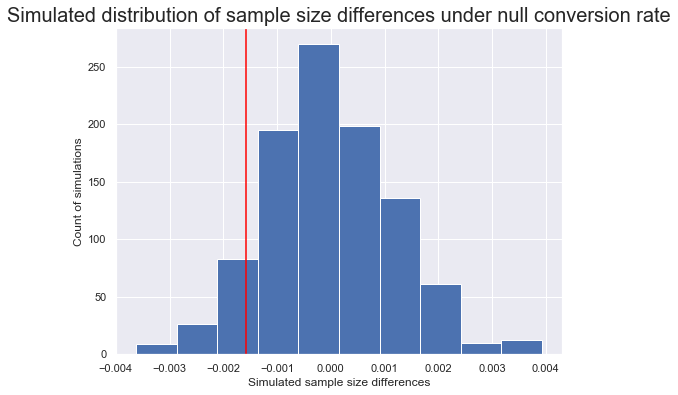

In [22]:
#for ease of visualization, the obseved difference is plotted as an x intercept red line over the previously calculated 
#normal distribution
plt.figure(figsize=(8,6))
plt.hist(p_diffs)
plt.title('Simulated distribution of sample size differences under null conversion rate', fontsize=20)
plt.xlabel('Simulated sample size differences', fontsize=12)
plt.ylabel('Count of simulations', fontsize=12)
plt.axvline(x=obs_diff, color='red');


## Interpreting the Simulated Results

Noting that the verticle red line in the previous histogram is the observed difference in simulated results, a p-value of the observed difference under the null hypothesis is around 0.90.  In other words, it is extremely likely that the control page has at least the conversion rate of the treatment page.  Typically, a p-value that disproves a null hypothesis is below 0.05 depending on the the data.

## Why Hypothesis Test?

Although it may seam easy to infer that the treatment page is not effective from the observed data, this is merely a guess without additional analysis.  The use of inferential statistics help remove some of the guess work from data analysis.